In [1]:
# Install required packages
# !pip install tensorflow
# !pip install keras
# !pip install keras-tuner
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
from tensorflow import keras

import keras_tuner as kt
import shap
shap.initjs()

import warnings

In [3]:
npca_X_train_data = pd.read_csv('data/impv/without_pca/X_train.csv')
npca_X_test = pd.read_csv('data/impv/without_pca/X_test.csv').values
npca_X_train = npca_X_train_data.values
npca_y_test = pd.read_csv('data/impv/without_pca/y_test.csv').values
npca_y_train = pd.read_csv('data/impv/without_pca/y_train.csv').values


X_test = pd.read_csv('data/impv/X_test.csv').values
X_train = pd.read_csv('data/impv/X_train.csv').values
y_test = pd.read_csv('data/impv/y_test.csv').values
y_train = pd.read_csv('data/impv/y_train.csv').values

### Building the model

In [4]:
def build_model(X_train, y_train):
    count = 1
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu', name="input_layer"))
    model.add(tf.keras.layers.Dense(64, activation='relu', name="hidden_1"))
    model.add(tf.keras.layers.Dense(64, activation='relu', name="hidden_2"))
    model.add(tf.keras.layers.Dense(1, name="output_layer")) 
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs = 200, verbose = 0, validation_split=0.2)
    return model, history

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error Life Expectancy')
    plt.legend()
    plt.grid(True)

### First model with compressed dataset after PCA

Following network architecture:
- One input layer with 64 output units and relu as activation function.
- Two hidden layers with 64 output units each and relue activation funciton.
- Output layers with 1 output units and linear (the default activation function in keras)

In [6]:
%%time
model1, history1 = build_model(X_train, y_train)

Wall time: 1min 42s


### Visaulise the network of first model

In [7]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 64)                640       
                                                                 
 hidden_1 (Dense)            (None, 64)                4160      
                                                                 
 hidden_2 (Dense)            (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


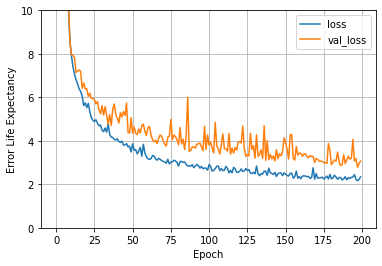

In [8]:
plot_loss(history1)

In [9]:
model1.evaluate(X_test, y_test, verbose=0)

2.857572078704834

### Second model without reducing dimension

In [10]:
%%time
model2, history2 = build_model(npca_X_train, npca_y_train)

Wall time: 1min 41s


In [11]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 64)                1216      
                                                                 
 hidden_1 (Dense)            (None, 64)                4160      
                                                                 
 hidden_2 (Dense)            (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________


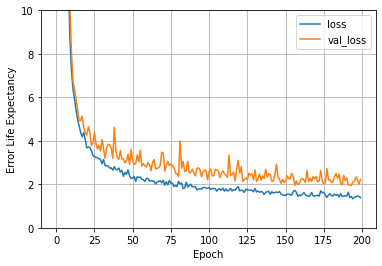

In [12]:
plot_loss(history2)

In [13]:
model2.evaluate(npca_X_test, npca_y_test, verbose=0)

1.9988572597503662

### Tuning some of the hyperparameters

Here we are trying to find the number of hidden layres and number of nueron on it.

In [14]:
def build_tune_model(hp):
    model = keras.Sequential()
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                  min_value=32,
                                                  max_value=512,
                                                  step=8),
                                     activation='relu'))
    
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse')
    return model

In [15]:
def Random_Search(project_name):
    tuner = kt.RandomSearch(
        build_tune_model,
        objective='val_loss',
        directory='project',
        project_name=project_name
    )
    return tuner

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [17]:
npca_tuner = Random_Search("life expectancy npca")
npca_tuner.search(npca_X_train, npca_X_train, epochs=200, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 14s]
val_loss: 0.9309148192405701

Best val_loss So Far: 0.9309136867523193
Total elapsed time: 00h 03m 13s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_model3 = npca_tuner.get_best_hyperparameters(num_trials=1)[0]

### Third model without reducing dimension

In [19]:
%%time
model3 = npca_tuner.hypermodel.build(best_model3)
history3 = model3.fit(npca_X_train, npca_y_train, epochs=200, validation_split=0.2, verbose = 0)

Wall time: 2min 58s


In [20]:
val_loss_per_epoch1 = history3.history['val_loss']
best_epoch = val_loss_per_epoch1.index(min(val_loss_per_epoch1)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 191


In [21]:
%%time
hypermodel1 = npca_tuner.hypermodel.build(best_model3)
# Retrain the model
history3 = hypermodel1.fit(npca_X_train, npca_y_train, epochs=best_epoch, validation_split=0.2, verbose = 0)

Wall time: 2min 44s


In [22]:
hypermodel1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 352)               6688      
                                                                 
 dense_11 (Dense)            (None, 320)               112960    
                                                                 
 dense_12 (Dense)            (None, 400)               128400    
                                                                 
 dense_13 (Dense)            (None, 64)                25664     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 273,777
Trainable params: 273,777
Non-trainable params: 0
_________________________________________________________________


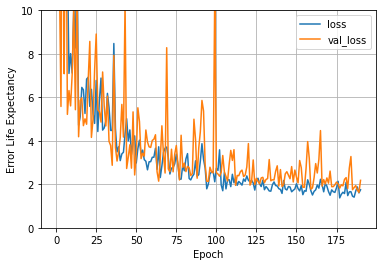

In [23]:
plot_loss(history3)

In [24]:
hypermodel1.evaluate(npca_X_test, npca_y_test, verbose=0)

1.9281240701675415

### Fourth model without reducing dimension

In [26]:
tuner = Random_Search("life expectancy")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 07s]
val_loss: 8.139677047729492

Best val_loss So Far: 4.257599830627441
Total elapsed time: 00h 02m 29s
INFO:tensorflow:Oracle triggered exit


In [27]:
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

In [28]:
%%time

model4 = tuner.hypermodel.build(best_model)
history4 = model4.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose = 0,)

Wall time: 1min 46s


In [29]:
val_loss_per_epoch2 = history4.history['val_loss']
best_epoch = val_loss_per_epoch2.index(min(val_loss_per_epoch2)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 192


In [30]:
%%time
hypermodel2 = tuner.hypermodel.build(best_model)
# Retrain the model
history4 = hypermodel2.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, verbose = 0)

Wall time: 1min 42s


In [31]:
hypermodel2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 400)               4000      
                                                                 
 dense_10 (Dense)            (None, 32)                12832     
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 18,977
Trainable params: 18,977
Non-trainable params: 0
_________________________________________________________________


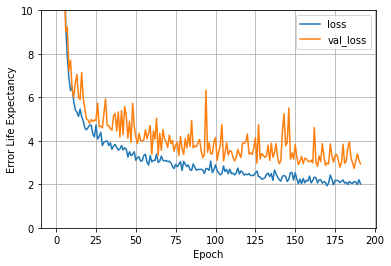

In [32]:
plot_loss(history4)

In [33]:
hypermodel2.evaluate(X_test, y_test, verbose=0)

2.7040529251098633

### Best performing model interpertation

Let's try to identify the impact of features on the output of model using <a href="https://shap.readthedocs.io/en/latest/index.html">SHAP</a> package.

In [34]:
warnings.filterwarnings('ignore')

In [35]:
%%time
train_summary = shap.kmeans(npca_X_train, 10)
explainer = shap.KernelExplainer(hypermodel1.predict, train_summary)
shap_values = explainer.shap_values(npca_X_train)

  0%|          | 0/5913 [00:00<?, ?it/s]

Wall time: 5h 8min 34s


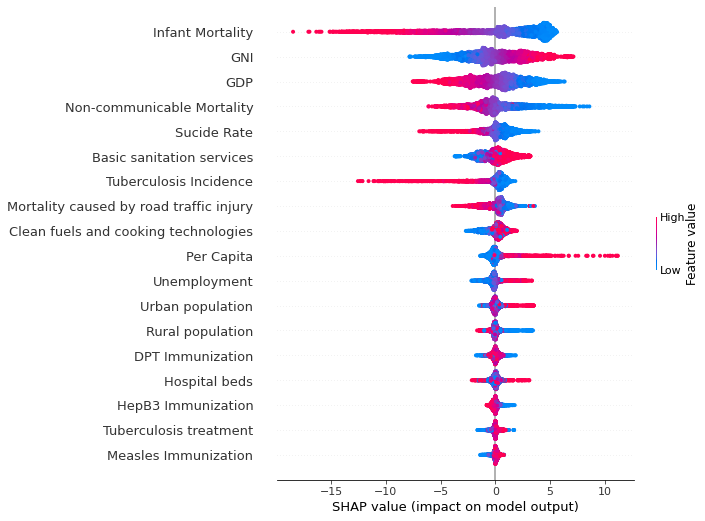

In [36]:
shap.summary_plot(shap_values[0], npca_X_train_data)